In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import os
os.chdir("../..")


In [189]:
import numpy as np
import json
import matplotlib.pyplot as plt

from collections import namedtuple
from typing import Callable


In [212]:
from qml.model.gate import Gateset
from qml.model.unit import UnitManager, Unit
from qml.model.model import Model
from qml.model.encoding import EncodingUnitManager
from qml.optimizer import evaluator as xeval
from qml import optimizer as xoptim
from qml.tools.dataset import Dataset
from qml.tools.random import XRandomGenerator
from qml.tools.typing import Vector


In [126]:
# circuit params
num_qubits = nq = 2
num_gates = ng = 3
dim_wavelet = dw = 4
dim_input = 1
dim_output = 1

# training params
batch_size = 4
lr = 1e-3
beta = 0.5

# QCG training db
ml_db_size = 10
dim_freq = 4
num_iter = 100
wavelet = xeval.Haar()
num_candidates = 5


In [49]:
def generate_random_target_func(dim_frequency):
    df = dim_frequency
    flags_select = np.random.choice([0, 1], size=[2, df], replace=True)
    coefficients = np.random.normal(0., 1., size=[2, df])

    def base_func(x):
        fxs = [f * x for f in range(1, df+1)]
        waves = np.vstack([np.sin(fxs), np.cos(fxs)]) * coefficients * flags_select
        return waves.sum()

    xs = np.linspace(-1, 1, 500)
    ys = np.asarray([base_func(x) for x in xs])

    ymax = ys.max()
    ymin = ys.min()
    def func(x):
        base_y = base_func(x)
        y = (base_y - ymin) / (ymax - ymin) * 2 - 1
        return y
    
    return func


In [105]:
def generate_random_dataset(size, dim_frequency):
    func = generate_random_target_func(dim_frequency)
    xs = np.linspace(-1, 1, size)
    ys = np.asarray([func(x) for x in xs])
    dataset = Dataset(xs, ys)
    return dataset


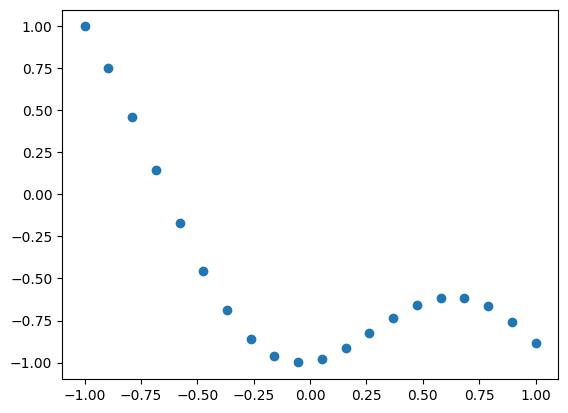

In [107]:
dataset = generate_random_dataset(20, 4)
plt.scatter(x=dataset.xs, y=dataset.ys)


In [ ]:
eval_avons = xeval.MSEEvaluator(dataset, orig_model, ml_db_size)


In [116]:
def generate_encoding_circuit(num_qubits):
    eunit = EncodingUnitManager.AngleEncoding(1, num_qubits, repeat=True)
    model = Model(num_qubits, 1, eunit, [], [])
    return model


In [125]:
def generate_new_circuit(num_qubits, num_gates, num_circuit=1):
    eunit = EncodingUnitManager.AngleEncoding(1, num_qubits, repeat=True)
    uman = UnitManager(num_qubits, num_gates)
    tunits = [uman.generate_random_unit() for _ in range(num_circuit)]
    models = [
        Model(num_qubits, 1, eunit, [], tunit)
        for tunit in tunits
    ]
    return models


In [136]:
def add_random_circuits(model, num_gates, num_circuits=1):
    uman = UnitManager(model.nq, num_gates)
    tunits = [uman.generate_random_unit() for _ in range(num_circuits)]
    model.fix_trainable_units()
    new_models = [
        Model(model.nq, 1, model.input_units, model.fixed_units, tunit)
        for tunit in tunits
    ]
    return new_models


In [167]:
def evaluate_candidate(model, dataset, evaluator_class, optimizer_class, num_iter=100, verbose=False):
    evaluator = evaluator_class(dataset, model)
    optimizer = optimizer_class(dataset)
    log = optimizer.optimize(model, num_iter, batch_size=dataset.size, verbose=verbose)
    result = evaluator(log.first.x)
    return float(result.loss)


In [177]:
def make_db_json(pwseriese, units, losses):
    if isinstance(pwseriese, np.ndarray):
        pwseriese = pwseriese.tolist()
    if isinstance(units[0], Unit):
        units = [unit.to_dict() for unit in units]
    if isinstance(losses, np.ndarray):
        losses = losses.tolist()
    data = dict(
        pwseries=pwseriese,
        units=units,
        losses=losses,
    )
    djson = json.dumps(data)
    return djson


In [168]:
# prepare MQC
dataset = generate_random_dataset(ml_db_size, dim_freq)
original_model = generate_encoding_circuit(num_qubits)
original_eval = xeval.WaveletEvaluator(wavelet, dataset, original_model, wavelet_dim=dim_wavelet)
original_eres = eval_avons()
original_eres.powers


array([-0.35186885, -0.22131685, -0.054984  , -0.21260244,  0.11221558,
        0.05768361, -0.30534191, -0.16369781,  0.02673038,  0.02909436,
        0.07377769,  0.03359864, -0.05939802, -0.13597831, -0.10046404])

In [170]:
# add candidates
candidate_models = add_random_circuits(original_model, num_gates, num_candidates)
losses = [
    evaluate_candidate(candidate_model, dataset, xeval.MSEEvaluator, xoptim.LocalSearchOptimizer, num_iter=10)
    for candidate_model in candidate_models
]
losses


[0.6885289143350157,
 0.7195829980530137,
 0.6781153076766089,
 0.6717135504184827,
 0.6005575038471156]

In [171]:
candidate_units = [
    candidate_model.trainable_units[0]
    for candidate_model in candidate_models
]


In [178]:
# build db
db = make_db_json(original_eres.powers, candidate_units, losses)


In [179]:
db


'{"pwseries": [-0.35186885366578025, -0.22131685465470446, -0.05498399572141142, -0.21260243748994084, 0.11221557754544362, 0.0576836121657223, -0.3053419143395725, -0.16369781420838053, 0.026730377924908556, 0.02909436379634873, 0.07377768615669011, 0.03359864134201081, -0.05939802218927759, -0.1359783073211819, -0.10046403958834586], "units": [{"name": "unit_0", "gates": ["ry", "cz", "rz"], "qubits": [1, 0, 1], "params": [0.0, 0.0]}, {"name": "unit_1", "gates": ["cz", "rz", "rx"], "qubits": [0, 1, 0], "params": [0.0, 0.0]}, {"name": "unit_2", "gates": ["rx", "cz", "cz"], "qubits": [1, 0, 0], "params": [0.0]}, {"name": "unit_3", "gates": ["cz", "cz", "ry"], "qubits": [1, 1, 0], "params": [0.0]}, {"name": "unit_4", "gates": ["cz", "rz", "ry"], "qubits": [0, 1, 0], "params": [0.0, 0.0]}], "losses": [0.6885289143350157, 0.7195829980530137, 0.6781153076766089, 0.6717135504184827, 0.6005575038471156]}'

## Build class OCGTrainingData

In [193]:
class TrigonometricTargetFuncGenerator:

    def __init__(self, dim_freq: int, seed: int = None):
        self.rng = XRandomGenerator(seed)
        self.df = dim_freq
    
    def generate(self):
        df = self.df
        flags_select = self.rng.choice([0, 1], size=[2, df], replace=True)
        coefficients = self.rng.normal(0., 1., size=[2, df])

        def base_func(x):
            fxs = [f * x for f in range(1, df+1)]
            waves = np.vstack([np.sin(fxs), np.cos(fxs)]) * coefficients * flags_select
            return waves.sum()

        xs = np.linspace(-1, 1, 500)
        ys = np.asarray([base_func(x) for x in xs])

        ymax = ys.max()
        ymin = ys.min()
        def func(x):
            base_y = base_func(x)
            y = (base_y - ymin) / (ymax - ymin) * 2 - 1
            return y
        
        return func


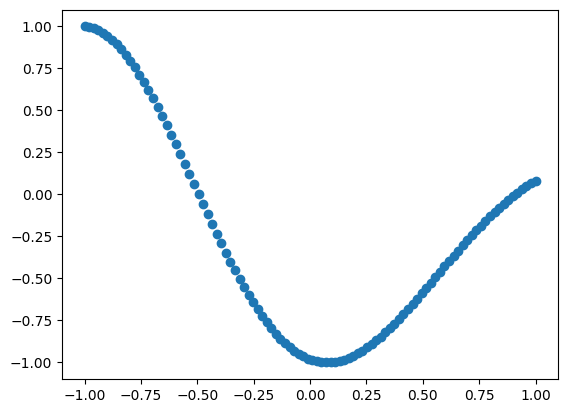

In [194]:
fgen = TrigonometricTargetFuncGenerator(dim_freq)
func = fgen.generate()
xs = np.linspace(-1, 1, 100)
ys = np.asarray([func(x) for x in xs])
plt.scatter(xs, ys)


In [195]:
class MLDataGenerator:

    def __init__(self, function_generator: Callable, seed: int = None):
        self.rng = XRandomGenerator(seed)
        self.fgen = function_generator
    
    def generate(self, size: int):
        xs = self.rng.uniform(-1, 1, size)
        ys = np.asarray([self.fgen(x) for x in xs])
        return Dataset(xs, ys)


In [ ]:
class OCGTrainingData:

    def __init__(
            self,
            wseries: Vector,
            uinfo,
            losses,
    ):
        pass

    @classmethod
    def make(
        cls,
        wseries: Vector,
        uinfo,
        losses: Vector
    ) -> "OCGTrainingData":
        

In [264]:
class OCGTrainingDataGenerator:

    def __init__(self, num_qubits, num_gates, dim_freq, shots=50, seed: int = None):
        self.rng = XRandomGenerator(seed)
        self.nq = num_qubits
        self.ng = num_gates
        self.df = dim_freq

        self.dim_input = 1
        self.dim_output = 1
        self.shots = shots

        self.uman = UnitManager(num_qubits, num_gates, seed=self.rng.new_seed())

    # general tools
    def build_initial_circuit(self):
        eunit = EncodingUnitManager.AngleEncoding(self.dim_input, self.nq, repeat=True)
        return Model(self.nq, self.dim_output, eunit, [], [])
    
    def append_new_units(self, model, units, skip_fix=False):
        if not skip_fix:
            model.fix_trainable_units()
        return [
            Model(self.nq, self.dim_output, model.input_units, model.fixed_units, unit)
            for unit in units
        ]

    # random unit data
    def add_radnom_units(self, model, size):
        units = [self.uman.generate_random_unit() for _ in range(size)]
        return self.append_new_units(model, units)
    
    def generate_random_db(self, size: int, max_iter_elever):
        db = []
        
    
    

# 1. dataset
dataset = 

ogen = OCGTrainingDataGenerator(2, 3, 4)
mqc = ogen.build_initial_circuit()
candidates = ogen.add_radnom_units(mqc, 5)

for candidate in candidates:
    evaluator = xeval.MSEEvaluator()

    

### Procedure de faire la dataset pour OCGTraining

#### parameters
Nc: Number of candidates in single dataset

#### avec Random Units
1. Prepare MQC avec Encoding
2. Calculate Wavelet seriese and loss -> wseries, loss_avons
3. Append candidate units x Nc --> units: json
4. Training candidates
5. Calculate loss --> loss_apres
6. Store into db --> db = db & {wseries, units, loss_apres}

7. repeat step 2 - 5 until loss threashold {threashold_loss} ou max number for repeats {num_iter_elever}

<Axes: >

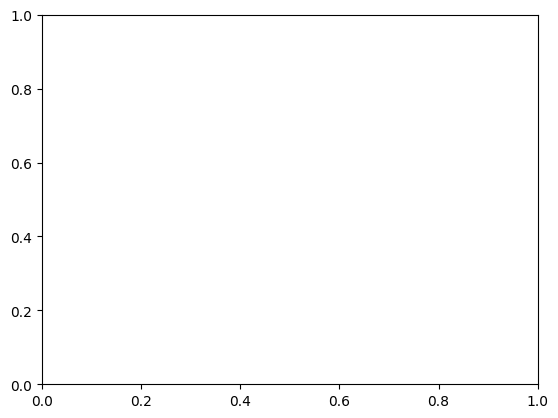

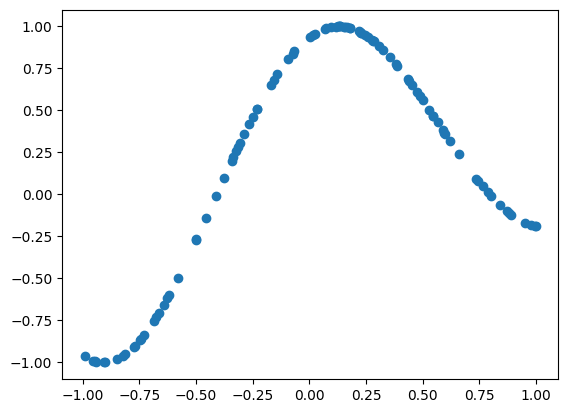

In [203]:
fgen = TrigonometricTargetFuncGenerator(dim_freq)
dgen = MLDataGenerator(fgen.generate())
dataset = dgen.generate(100)
plt.scatter(dataset.xs, dataset.ys)
